PyTorch implementation of the paper:


M. Afifi, A. Abuolaim, M. Hussien,  M. A. Brubaker, and M. S. Brown. CAMS: Color-Aware Multi-Style Transfer. arXiv preprint arXiv:2106.13920, 2021.

# Libraries

In [66]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import copy
import cv2
import math
from torchvision.utils import save_image

# Settings

Input images

In [67]:
STYLE_IMAGE = "//content//style.jpg"
CONTENT_IMAGE = "//content//content.jpg"

Settings

In [68]:
SMOOTH = True
SHOW_MASKS = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SELECT_MATCHES = False # set to True to select color correspondences in palettes
EPS = 1e-6
SIGMA = 0.25 # 0.25 and 0.3 work well in most cases
PALETTE_SIZE = 5
ADD_BLACK_WHITE = False
STYLE_LOSS_WEIGHT = 10000
CONTENT_LOSS_WEIGHT = 1
COLOR_DISTANCE = 'chroma_L2'  # Options: 'chroma_L2', 'L2'
STYLE_FEATURE_DISTANCE = 'L2'  # Options: 'L2', 'COSINE'
CONTENT_FEATURE_DISTANCE = 'L2'  # Options: 'L2', 'COSINE'
OPTIMIZER = 'LBFGS'  # Options: 'LBFGS', 'Adam', 'Adagrad'
LR = 0.5
ITERATIONS = 300
IMAGE_SIZE = 384
# desired size of the output image
imsize = IMAGE_SIZE if torch.cuda.is_available() else 128
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4', 'conv_5']
color_aware_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Color palette
Ref: https://github.com/tody411/PaletteSelection

Helper functions

This code is a collection of functions for image processing and color analysis. Key functionalities include:
Converting images between different data types and color spaces (RGB and Lab).
Analyzing image colors by calculating color histograms, normalizing color densities, and filtering out less significant colors.
Utility functions for checking image types, computing norms of vectors, and assisting in color data representation.
Support for plotting and visualization, specifically for setting up axis ticks and limits.

In [69]:
import numpy as np
import cv2

def to32F(img):
    return np.float32(img) / 255.0 if img.dtype != np.float32 else img

def rgb(img):
    if img.ndim == 2:
        return np.stack((img,)*3, axis=-1)
    return img[..., :3] if img.shape[-1] >= 3 else img

def rgb2Lab(img):
    return cv2.cvtColor(rgb(img), cv2.COLOR_RGB2LAB)

def _isGray(image):
    return len(image.shape) == 2

def Lab2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_LAB2RGB)

def isVector(x):
    return x.ndim == 1

def l2NormVectors(x):
    return np.einsum('...i,...i', x, x) if not isVector(x) else np.square(x)

def normVectors(x):
    return np.sqrt(l2NormVectors(x))

def colorCoordinates(color_ids, num_bins, color_range):
    c_min, c_max = color_range
    return c_min + (np.array(color_ids).T * (c_max - c_min)) / (num_bins - 1.0)

def colorDensities(hist_bins):
    hist_positive = hist_bins > 0
    color_densities = np.float32(hist_bins[hist_positive]) / np.max(hist_bins)
    return color_densities

def rgbColors(hist_bins, color_bins):
    hist_positive = hist_bins > 0
    return np.clip(color_bins[hist_positive, :], 0.0, 1.0)

def clipLowDensity(hist_bins, color_bins, alpha):
    density_mean = np.mean(hist_bins)
    low_density = hist_bins < density_mean * alpha
    hist_bins[low_density] = 0.0
    color_bins[low_density] = 0.0

def densitySizes(color_densities, density_size_range):
    min_size, max_size = density_size_range
    factor = max_size / min_size
    return min_size * np.power(factor, color_densities)

def range2ticks(tick_range, decimals=1):
    ticks = np.around(tick_range, decimals=decimals)
    ticks[ticks > 10] = np.rint(ticks[ticks > 10])
    return ticks

def range2lims(tick_range):
    unit = 0.1 * np.ptp(tick_range, axis=1)
    return tick_range + np.column_stack((-unit, unit))

Color pixels class

The ColorPixels class is designed for extracting and analyzing pixel data from images. It supports different color spaces, mainly RGB and Lab. Key features include:

Initializing the image data in a normalized float format.
Extracting RGB pixels of the image.
Converting and extracting Lab color space pixels.
General method for obtaining pixel data in specified color spaces.
Handling both grayscale and color images to extract a representative subset of pixels.

In [70]:
class ColorPixels:

    def __init__(self, image, num_pixels=1000):
        self._image = to32F(image)
        self._num_pixels = num_pixels
        self._rgb_pixels = None
        self._Lab = None
        self._hsv = None

    ## RGB pixels.
    def rgb(self):
        if self._rgb_pixels is None:
            self._rgb_pixels = self.pixels("rgb")
        return self._rgb_pixels

    ## Lab pixels.
    def Lab(self):
        if self._Lab is None:
            self._Lab = self.pixels("Lab")
        return self._Lab

    ## Pixels of the given color space.
    def pixels(self, color_space="rgb"):
        image = np.array(self._image)

        if color_space == "Lab":
            image = rgb2Lab(self._image)

        return self._image2pixels(image)

    def _image2pixels(self, image):
        if _isGray(image):
            h, w = image.shape
            step = int(h * w / self._num_pixels)
            return image.reshape((h * w))[::step]

        h, w, cs = image.shape
        step = int(h * w / self._num_pixels)
        return image.reshape((-1, cs))[::step]

3D color histograms

The Hist3D class is used for generating and analyzing 3D color histograms from images. Key functionalities include processing images in different color spaces, calculating color histograms, and extracting color information like color IDs, coordinates, densities, and RGB values. The class also includes a feature for filtering out low-density colors in the histogram. This is particularly useful for advanced color analysis in image processing tasks.

In [71]:
import numpy as np

class Hist3D:
    def __init__(self, image, num_bins=16, alpha=0.1, color_space='rgb'):
        self.color_pixels = ColorPixels(image)
        self.num_bins = num_bins
        self.alpha = alpha
        self.color_space = color_space
        self.pixels = self.color_pixels.pixels(color_space)
        self.rgb_pixels = self.color_pixels.rgb()
        self.color_range = self._computeColorRange()
        self.hist_bins, self.color_bins = self._computeHistogram()

    def colorSpace(self):
        return self.color_space

    def colorIDs(self):
        return np.where(self.hist_bins > 0)

    def colorCoordinates(self):
        return colorCoordinates(self.colorIDs(), self.num_bins, self.color_range)

    def colorDensities(self):
        return colorDensities(self.hist_bins)

    def rgbColors(self):
        return rgbColors(self.hist_bins, self.color_bins)

    def _computeColorRange(self):
        c_min = np.min(self.pixels, axis=0)
        c_max = np.max(self.pixels, axis=0)
        return [c_min, c_max]

    def _computeHistogram(self):
        c_min, c_max = self.color_range
        hist_bins = np.zeros((self.num_bins, self.num_bins, self.num_bins), dtype=np.float32)
        color_bins = np.zeros_like(hist_bins, shape=(self.num_bins, self.num_bins, self.num_bins, 3))

        color_ids = np.int32((self.num_bins - 1) * (self.pixels - c_min) / (c_max - c_min))

        for pi, color_id in enumerate(color_ids):
            hist_bins[tuple(color_id)] += 1
            color_bins[tuple(color_id)] += self.rgb_pixels[pi]

        hist_positive = hist_bins > 0
        color_bins[hist_positive] /= hist_bins[hist_positive, None]

        self._clipLowDensity(hist_bins, color_bins)

        return hist_bins, color_bins

    def _clipLowDensity(self, hist_bins, color_bins):
        clipLowDensity(hist_bins, color_bins, self.alpha)

Auto palette selection

The PaletteSelection class automatically selects a distinct color palette from an image, based on color coordinates, densities, and RGB values. It iteratively chooses the most representative colors, adjusting weights to ensure variety in the selected palette. This class is useful for applications requiring concise color summarization from complex images.

In [72]:
## Implementation of automatic palette selection.
class PaletteSelection:
    def __init__(self, color_coordinates, color_densities, rgb_colors,
                 num_colors=7, sigma=70.0):
        self._color_coordinates = color_coordinates
        self._color_densities = color_densities
        self._rgb_colors = rgb_colors
        self._num_colors = num_colors
        self._sigma = sigma
        self._palette_coordinates = []
        self._palette_colors = []
        self._computeDarkBrightColors()
        self._computeInitialWeight()
        self._compute()

    def paletteCoordinates(self):
        return self._palette_coordinates

    def paletteColors(self):
        return self._palette_colors

    def _compute(self):
        for i in range(self._num_colors):
            palette_coordinate = self._updatePalette()
            self._updateWeight(palette_coordinate)

    def _computeDarkBrightColors(self):
        rgb_colors = self._rgb_colors

        intensities = normVectors(rgb_colors)
        c_dark = self._color_coordinates[np.argmin(intensities)]
        c_bright = self._color_coordinates[np.argmax(intensities)]
        self._dark_bright = [c_dark, c_bright]

    def _computeInitialWeight(self):
        self._color_weights = np.array(self._color_densities)
        self._updateWeight(self._dark_bright[0])
        self._updateWeight(self._dark_bright[1])

    def _updatePalette(self):
        color_id = np.argmax(self._color_weights)
        palette_coordinate = self._color_coordinates[color_id]
        self._palette_coordinates.append(palette_coordinate)

        palette_color = self._rgb_colors[color_id]
        self._palette_colors.append(palette_color)
        return palette_coordinate

    def _updateWeight(self, palette_coordinate):
        dists = normVectors(self._color_coordinates - palette_coordinate)
        factors = 1.0 - np.exp(- dists ** 2 / (self._sigma ** 2))
        self._color_weights = factors * self._color_weights


Mask generation

The CreateMask class is a PyTorch module for generating color-based masks from an image using a specified color palette. It adjusts image size, computes distance from each color in the palette, and applies optional Gaussian smoothing. This class is useful for tasks like image segmentation where masks for specific colors are needed.

In [73]:
class CreateMask(nn.Module):
    def __init__(self, insz=imsize, color_palette=None, sigma=SIGMA, smooth=SMOOTH, distance=COLOR_DISTANCE):
        super(CreateMask, self).__init__()
        self.color_palette = color_palette
        self.insz = insz
        self.sigma = sigma
        self.distance = distance
        self.smooth = smooth

    def forward(self, x):
        if self.color_palette is None:
            raise ValueError('No color palette is given')
        x = torch.clamp(x, 0, 1)
        I = F.interpolate(x, size=(self.insz, self.insz), mode='bilinear', align_corners=False)
        masks = torch.zeros(1, self.color_palette.shape[0], self.insz, self.insz, device=x.device)
        I = I[:, :3, :, :] if I.shape[1] > 3 else I

        for c, color in enumerate(self.color_palette):
            color = color.view(1, 3, 1, 1)
            dist = self._calculate_distance(I, color)
            weight = torch.exp(-1 * (dist / self.sigma) ** 2)

            if self.smooth:
                weight = F.conv2d(weight.unsqueeze(0), gaussian_kernel, padding=7).squeeze(0)

            masks[0, c] = weight
        return masks

    def _calculate_distance(self, I, color):
        if self.distance == 'chroma_L2':
            I = self._normalize_chroma(I)
            color = self._normalize_chroma(color)
        return torch.sqrt(torch.sum((I - color) ** 2, dim=1))

    @staticmethod
    def _normalize_chroma(tensor):
        return tensor / (torch.sum(tensor, dim=1, keepdim=True) + EPS)

# Loss Functions

Gram matrix

The gram_matrix function calculates the Gram matrix of a given input tensor, commonly used in neural network applications like style transfer. It flattens the feature maps of the tensor, computes the Gram matrix by multiplying these flattened maps with their transpose, and then normalizes this matrix. This process captures and normalizes the correlations between different feature maps in the tensor.

In [74]:
def gram_matrix(input_tensor):
    # Extract the dimensions: batch size (num_batches), number of feature maps (num_features),
    # and dimensions of each feature map (height, width).
    num_batches, num_features, height, width = input_tensor.size()

    # Flatten the feature maps. The result is a 2D tensor where each row is a flattened feature map.
    flattened_features = input_tensor.view(num_batches * num_features, height * width)

    # Compute the Gram matrix by multiplying the flattened feature tensor with its transpose.
    # The result captures the correlation between different feature maps.
    gram = torch.mm(flattened_features, flattened_features.t())

    # Normalize the Gram matrix by dividing it by the total number of elements in the original tensor.
    # This step prevents larger feature maps from disproportionately influencing the result.
    normalized_gram = gram / (num_batches * num_features * height * width)

    return normalized_gram

Masked Gram matrix

The compute_masked_gram function calculates Gram matrices for an input tensor, each modified by a different mask from a set of masks. It involves resizing the masks to the input's dimensions, normalizing them, and applying them to the input tensor. For each mask, the function computes a masked Gram matrix by considering only the active (masked) areas, and then normalizes this matrix based on the sum of mask values. The final output is the average of these normalized Gram matrices for all masks. This function is useful for style transfer applications where different style features need to be applied to specific regions of an image.

In [75]:
def compute_masked_gram(input_tensor, mask_tensor):
    num_masks = mask_tensor.shape[1]
    batch_size, num_features, height, width = input_tensor.size()

    # Resize the masks to match the input tensor's dimensions
    resized_masks = F.interpolate(mask_tensor, size=(height, width), mode='bilinear', align_corners=False)

    # Initialize the Gram matrix for each mask
    gram_matrices = torch.zeros(num_masks, batch_size * num_features * batch_size * num_features, device=DEVICE)

    # Reshape the input tensor for matrix multiplication
    input_features = input_tensor.view(batch_size * num_features, height * width)

    # Process each mask
    for idx in range(num_masks):
        current_mask = resized_masks[:, idx, :, :].view(batch_size, height * width)
        # Normalize current mask
        normalized_mask = (current_mask - torch.min(current_mask)) / (torch.max(current_mask) - torch.min(current_mask))

        # Calculate the number of effective elements
        effective_elements = torch.sum(normalized_mask)

        # Apply the mask and compute the Gram matrix
        masked_features = input_features * normalized_mask
        single_gram_matrix = torch.mm(masked_features, masked_features.t())

        # Normalize and store the computed Gram matrix
        gram_matrices[idx, :] = single_gram_matrix.div(effective_elements).view(1, batch_size * num_features * batch_size * num_features)

    # Return the average of all computed Gram matrices
    return gram_matrices / num_masks

Content loss

The CustomContentLoss class in this code is a PyTorch neural network module for calculating content loss. It computes the loss between a target feature and a current feature based on a predefined distance metric, which can be either L2 (mean squared error) or cosine similarity. This class is typically used in applications like neural style transfer to measure and minimize the difference between generated and target features.

In [76]:
import torch.nn as nn
import torch.nn.functional as F

class CustomContentLoss(nn.Module):
    def __init__(self, target_feature):
        super(CustomContentLoss, self).__init__()
        self.stored_target = target_feature.detach()

    def forward(self, current_feature):
        # Selecting the loss calculation method based on a predefined distance metric
        if CONTENT_FEATURE_DISTANCE == 'L2':
            self.loss = F.mse_loss(current_feature, self.stored_target)
        elif CONTENT_FEATURE_DISTANCE == 'COSINE':
            self.loss = calculate_cosine_similarity(current_feature, self.stored_target)
        else:
            raise NotImplementedError("The specified content feature distance method is not implemented.")

        return current_feature

Cosine similarity

calculate_cosine_similarity: This function calculates the cosine similarity between two tensors. It flattens the tensors, computes the cosine similarity by dividing their dot product by the product of their norms, and returns one minus the similarity score.

update_grad_requirement: This function iterates through the parameters of a neural network model and sets their requires_grad attribute as per the given boolean value. This is used to enable or disable gradient computations for the model's parameters during training or evaluation.

In [77]:
def calculate_cosine_similarity(tensor_a, tensor_b):
    flattened_a = tensor_a.view(1, -1)
    flattened_b = tensor_b.view(1, -1)
    cosine_sim = torch.sum(flattened_a * flattened_b) / (flattened_a.norm(2) * flattened_b.norm(2) + EPS)
    return 1 - cosine_sim

def update_grad_requirement(neural_model, requires_grad):
    for param in neural_model.parameters():
        param.requires_grad = requires_grad

Color-aware loss

The ColorAwareLoss class in PyTorch calculates style loss for style transfer, considering color-specific regions. It computes masked Gram matrices for both target and input features, and the loss is measured using either L2 norm or cosine similarity. This approach allows for color-sensitive style applications in neural networks.

In [78]:
class ColorAwareLoss(nn.Module):
    def __init__(self, target_feature, target_masks):
        super(ColorAwareLoss, self).__init__()
        self.target = compute_masked_gram(target_feature, target_masks).detach()
        self.input_masks = target_masks

    def set_input_masks(self, input_masks):
        self.input_masks = input_masks

    def forward(self, input):
        G = compute_masked_gram(input, self.input_masks)
        if STYLE_FEATURE_DISTANCE == 'L2':
            self.loss = F.mse_loss(G, self.target)
        elif STYLE_FEATURE_DISTANCE == 'COSINE':
            self.loss = calculate_cosine_similarity(G, self.target)
        else:
            raise NotImplementedError

        return input

# Image loader and visualization

Image loader

The image_loader function loads an image, computes its color palette using a 3D histogram in the Lab color space, and then selects a palette of K colors. It uses these colors to create a tensor representing the chosen palette. Additionally, the function transforms the image into a tensor suitable for neural network input, including adding a batch dimension. The output is a tuple of the transformed image tensor and the color palette tensor, both moved to the specified device.

In [79]:
def image_loader(image_name, K=16):
    image = Image.open(image_name)
    # compute color palette
    img_array = np.array(image)
    # 16 bins, Lab color space
    hist3D = Hist3D(img_array, num_bins=16, color_space='Lab')

    color_coordinates = hist3D.colorCoordinates()
    color_densities = hist3D.colorDensities()
    rgb_colors = hist3D.rgbColors()

    palette_selection = PaletteSelection(color_coordinates, color_densities,
                                         rgb_colors, num_colors=K, sigma=70.0)
    colors = palette_selection._palette_colors

    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(DEVICE, torch.float), torch.tensor(
        colors).to(DEVICE, torch.float)

Visualization

The imshow function displays an image from a PyTorch tensor. It first moves the tensor to the CPU and creates a clone to avoid modifying the original tensor. Then, it removes the batch dimension (if present) and converts the tensor back to a PIL image using the unloader function. The image is displayed using matplotlib, with an optional title if provided. The function includes a brief pause to ensure the plot is updated correctly.

In [80]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

# Other classes and functions

Normalization


The Normalization class is a custom PyTorch module designed to normalize input images. It standardizes the images based on the specified mean and standard deviation values. The mean and standard deviation are reshaped to be compatible with the input image's dimensions [B x C x H x W], where B is the batch size, C is the number of channels, and H and W are the height and width of the image, respectively. In the forward pass, this module normalizes the input image by subtracting the mean and dividing by the standard deviation, effectively standardizing each channel of the image. This normalization is a common practice in deep learning to facilitate model training.

In [81]:
# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Get optimizer

The get_input_optimizer function is designed to create and return an optimizer for an input image tensor in PyTorch. It selects the optimizer based on a predefined global variable OPTIMIZER. Depending on the value of OPTIMIZER, it can create one of the following optimizers: LBFGS, Adam, or Adagrad. The input image is set to require gradients, which is necessary for optimization. The learning rate for the optimizer is set using a global variable LR. If OPTIMIZER is set to a value other than 'LBFGS', 'Adam', or 'Adagrad', the function raises a NotImplementedError. This function is typically used in scenarios where the image itself is being optimized, such as in neural style transfer.

In [82]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    if OPTIMIZER == 'LBFGS':
        optimizer = optim.LBFGS([input_img.requires_grad_()], lr=LR)
    elif OPTIMIZER == 'Adam':
        optimizer = optim.Adam([input_img.requires_grad_()], lr=LR)
    elif OPTIMIZER == 'Adagrad':
        optimizer = optim.Adagrad([input_img.requires_grad_()], lr=LR)
    else:
        raise NotImplementedError


    return optimizer

Get style model and losses


The get_style_model_and_losses function customizes a CNN for style transfer by adding normalization and loss layers. It integrates CustomContentLoss layers for content fidelity and ColorAwareLoss layers for color-sensitive style features, tailored to specific layers of the CNN. The model is truncated after the last custom loss layer. The function returns the modified model along with the content and color-aware style loss layers for style transfer applications.

In [83]:
def get_style_model_and_losses(cnn, normalization_mean,
                               normalization_std,
                               style_img, content_img,
                               style_img_masks,
                               content_layers=content_layers_default,
                               #style_layers=style_layers_default,
                               color_aware_layers=color_aware_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean,
                                  normalization_std).to(DEVICE)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    color_aware_style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(
                layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss =CustomContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in color_aware_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            color_aware_loss = ColorAwareLoss(target_feature, style_img_masks)
            model.add_module("color_aware_loss_{}".format(i), color_aware_loss)
            color_aware_style_losses.append(color_aware_loss)

    for i in range(len(model) - 1, -1, -1):
        if (isinstance(model[i], CustomContentLoss) or
            isinstance(model[i], ColorAwareLoss)):
            break
    model = model[:(i + 1)]

    return model, content_losses, color_aware_style_losses


If SMOOTH is true, create a Gaussian blur kernel.

This code creates a normalized Gaussian blur kernel for image smoothing in PyTorch. It defines the kernel size and standard deviation, calculates the 2D Gaussian kernel, and normalizes it to ensure brightness preservation. The kernel is reshaped for convolutional operations and transferred to a specified computing device.

In [84]:
if SMOOTH:
    """# Gaussian blur kernel"""

    # Set these to whatever you want for your gaussian filter
    kernel_size = 15
    sigma = 5

    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_cord = torch.arange(kernel_size)
    x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1)

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance))
    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.to(device=DEVICE)

# Run style transfer

Main function to run style transfer

The run_style_transfer function performs neural style transfer by customizing a CNN model with content and color-aware style losses. It optimizes the input image over several iterations to blend the content of one image with the style of another, optionally updating and visualizing color masks during the process. The function returns the stylized image after completing the specified number of optimization steps.

In [85]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, style_img_masks,
                       num_steps=ITERATIONS, update_masks=True,
                       color_aware_weight=STYLE_LOSS_WEIGHT,
                       content_weight=CONTENT_LOSS_WEIGHT):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, content_losses, color_aware_losses = (
    get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img, style_img_masks))

    optimizer = get_input_optimizer(input_img)

    mask_generator = CreateMask(color_palette=final_palette)

    if not update_masks:
        input_masks = mask_generator(input_img).detach()
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ColorAwareLoss):
                model[i].set_input_masks(input_masks)

    print('Optimizing..')
    run = [0]

    while run[0] <= num_steps:
        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()

            if update_masks:
                input_masks = mask_generator(input_img).detach()


            if SHOW_MASKS and run[0] % 50 == 0:
                for i in range(final_palette.shape[0]):
                    plt.figure()
                    imshow(style_masks[:, i, :, :], title=f'Style Mask of Color # {i}')
                    plt.figure()
                    imshow(input_masks[:, i, :, :], title=f'Input Mask of Color # {i}')

            if update_masks:
                for i in range(len(model) - 1, -1, -1):
                    if isinstance(model[i], ColorAwareLoss):
                        model[i].set_input_masks(input_masks)


            model(input_img)

            content_score = 0
            color_aware_score = 0

            for cl in content_losses:
                content_score += cl.loss
            for cal in color_aware_losses:
                color_aware_score += cal.loss

            content_score *= content_weight
            color_aware_score *= color_aware_weight

            loss = content_score + color_aware_score

            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Content Loss: {:4f} Color-Aware Loss: {:4f}'.format(
                    content_score.item(), color_aware_score.item()))

            return content_score + color_aware_score


        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img


Main steps

This script executes a neural style transfer process in PyTorch. It loads and processes style and content images, generates color masks for color-aware style transfer, and visualizes them. The script uses a pretrained VGG-19 model for the style transfer. The transfer itself is conducted through an optimization loop, blending the style of one image with the content of another. Finally, the stylized output is displayed and saved. The process includes user interaction for custom mask generation and supports dynamic updates during the transfer.

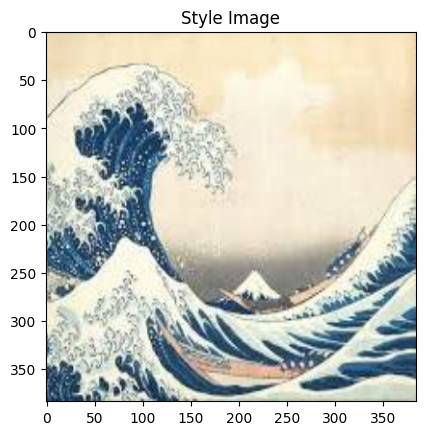

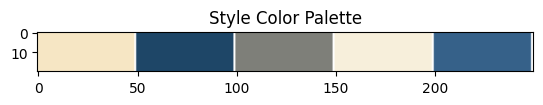

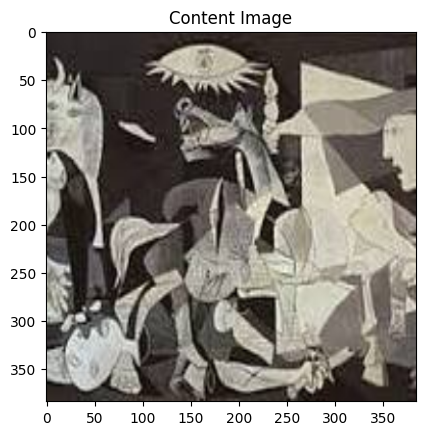

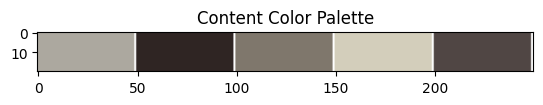

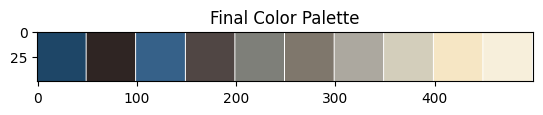

Building the style transfer model..
Optimizing..


<ipython-input-81-0432feddea55>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-81-0432feddea55>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Content Loss: 24.389940 Color-Aware Loss: 256.635864
run [100]:
Content Loss: 27.971783 Color-Aware Loss: 125.997131
run [150]:
Content Loss: 27.246407 Color-Aware Loss: 78.013130
run [200]:
Content Loss: 26.376638 Color-Aware Loss: 59.318672
run [250]:
Content Loss: 25.573816 Color-Aware Loss: 45.476822
run [300]:
Content Loss: 25.496109 Color-Aware Loss: 41.312061


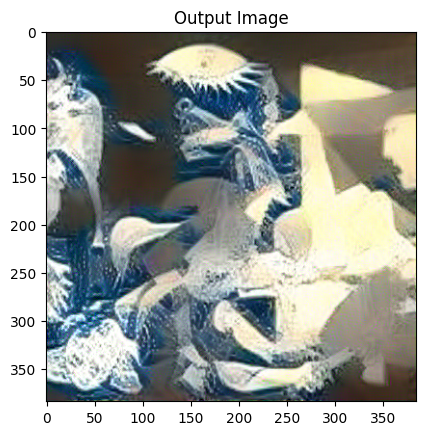

In [86]:

"""# Image Loader"""

loader = transforms.Compose([transforms.Resize((imsize, imsize)), transforms.ToTensor()])

unloader = transforms.ToPILImage()  # reconvert into PIL image

style_img, style_palette = image_loader(STYLE_IMAGE, PALETTE_SIZE)

content_img, content_palette = image_loader(CONTENT_IMAGE, PALETTE_SIZE)


assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"


""" Image visualization"""

plt.ion()

style_img_color_palette_vis = torch.ones((1, 3, 20, 50 * PALETTE_SIZE),
                                         device=DEVICE)
content_img_color_palette_vis = torch.ones((1, 3, 20,50 * PALETTE_SIZE),
                                           device=DEVICE)


for c in range(PALETTE_SIZE):
    style_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
        style_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
        style_palette[c, :].view(1, 3, 1, 1))
    content_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
        content_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
        content_palette[c, :].view(1, 3, 1, 1))


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(style_img_color_palette_vis, title='Style Color Palette')

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(content_img_color_palette_vis, title='Content Color Palette')

""" Mask generation"""

if SELECT_MATCHES:
    print('Please enter color matching order. ',
  'For example to link the first color of content palette to the third color',
  ' in style palette, please enter: 0, 2\n This will be repeated until you ',
  'enter -1.')
    user_input = input()
    matching_order_content = []
    matching_order_style = []
    while user_input != '-1':
        parts = str.split(user_input, ',')
        c = int(parts[0])
        s = int(parts[1])
        assert style_palette.shape[0] > s and content_palette.shape[0] > c
        matching_order_content.append(c)
        matching_order_style.append(s)
        user_input = input()
    sorted_style_order = np.sort(matching_order_style)
    style_palette = style_palette[sorted_style_order, :]
    sorting_inds = list(np.argsort(matching_order_style).astype(int))
    sorted_content_order = [matching_order_content[i] for i in sorting_inds]
    content_palette = content_palette[sorted_content_order, :]
    PALETTE_SIZE = len(sorted_content_order)
    style_img_color_palette_vis = torch.ones((1, 3, 20, 50 * PALETTE_SIZE),
                                         device=DEVICE)
    content_img_color_palette_vis = torch.ones((1, 3, 20,50 * PALETTE_SIZE),
                                           device=DEVICE)

    for c in range(PALETTE_SIZE):
        style_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
            style_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
              style_palette[c, :].view(1, 3, 1, 1))
        content_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
            content_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
          content_palette[c, :].view(1, 3, 1, 1))

    plt.figure()
    imshow(style_img_color_palette_vis, title='Final Style Color Palette')

    plt.figure()
    imshow(content_img_color_palette_vis, title='Matched Content Color Palette')

    final_palette = content_palette.clone()
    mask_generator_style = CreateMask(color_palette=style_palette)
    mask_generator_content = CreateMask(color_palette=content_palette)

else:
    final_palette = torch.cat([style_palette, content_palette], dim=0)
    if ADD_BLACK_WHITE:
        black_white = torch.tensor([[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]],
                           dtype=torch.float32, device=DEVICE)
        final_palette = torch.cat([final_palette, black_white], dim=0)

    final_palette = torch.unique(final_palette, dim=0)
    final_color_palette_vis = torch.ones((1, 3, 50, 50 * final_palette.shape[0]),
                                     device=DEVICE)
    for c in range(final_palette.shape[0]):
        final_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (final_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *final_palette[c, :].view(1, 3, 1, 1))
    plt.figure()
    imshow(final_color_palette_vis, title='Final Color Palette')
    mask_generator_style = CreateMask(color_palette=final_palette)
    mask_generator_content = CreateMask(color_palette=final_palette)


style_masks = mask_generator_style(style_img)

content_masks = mask_generator_content(content_img)

if SHOW_MASKS:
    for i in range(final_palette.shape[0]):
        plt.figure()
        imshow(style_masks[:, i, :, :], title=f'Style Mask of Color # {i}')
        plt.figure()
        imshow(content_masks[:, i, :, :], title=f'Content Mask of Color # {i}')


""" Loading VGG model"""

cnn = models.vgg19(pretrained=True).features.to(DEVICE).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)


input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=DEVICE)

""" Run style transfer"""

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, style_masks,
                            update_masks=not SELECT_MATCHES)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()


save_image(output.detach().squeeze(0), 'output.png')